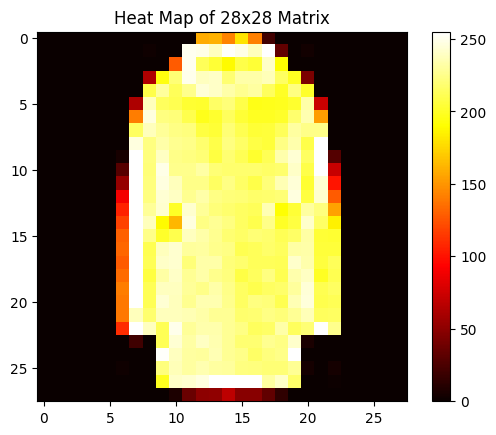

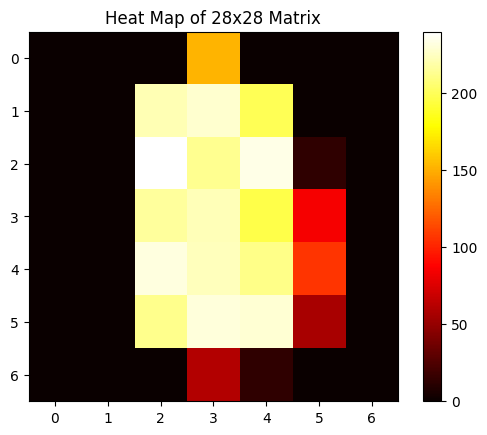

d:\vscode\python\python311\Lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
#%% Data prepare

import os
os.chdir("C:\\Users\\bigbi\\Desktop\\thesis")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import numpy as np 
import torch_geometric
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import torch_geometric.utils as utils
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import cv2

from scipy.ndimage import zoom
train = pd.read_csv('fashion-mnist_train.csv')
test = pd.read_csv('fashion-mnist_test.csv')

m1 = train.iloc[6,1:785]
m1 = m1.values.flatten()
m1 =  m1.reshape((28,28))
plt.imshow(m1, cmap='hot', interpolation='nearest')
plt.colorbar()  # Show color scale
plt.title('Heat Map of 28x28 Matrix')
plt.show()

m1 = zoom(m1,(0.25, 0.25),order=1)
#m1 = cv2.resize(m1, (7,7), interpolation=cv2.INTER_LINEAR)
plt.imshow(m1, cmap='hot', interpolation='nearest')
plt.colorbar()  # Show color scale
plt.title('Heat Map of 28x28 Matrix')
plt.show()


mnist_train = pd.read_csv('fashion-mnist_train.csv')
mnist_test = pd.read_csv('fashion-mnist_test.csv')
X_train = mnist_train.iloc[:, 1:].values  # Pixel values
y_train = mnist_train.iloc[:, 0].values   # Labels

X_test = mnist_test.iloc[:, 1:].values  # Pixel values
y_test = mnist_test.iloc[:, 0].values   # Labels

# Normalize pixel values to [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

xx, yy = torch.meshgrid(torch.arange(7), torch.arange(7))
pos = torch.stack([xx.flatten(), yy.flatten()], dim=1)

In [ ]:
#%% Convert to graph

from scipy.ndimage import zoom
import torch_geometric.utils as utils
from torch_geometric.utils import grid
def convert_to_graph(X, y):
    graphs = []
    for i in range(len(X)):
        img = X[i].reshape(28, 28)
        img = zoom(img,(0.25, 0.25),order=1)
        img = torch.tensor(img, dtype=torch.float).view(-1, 1)
        edge_index = grid(7, 7)
        #edge_index = grid(28, 28)
        edge_index = edge_index[0]
        graphs.append(Data(x=img, edge_index=edge_index, y=torch.tensor([y[i]], dtype=torch.long)))
    return graphs

train_graphs = convert_to_graph(X_train, y_train)
test_graphs = convert_to_graph(X_test, y_test)


# Use DataLoader to load data
train_loader = DataLoader(train_graphs, batch_size=64, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=64, shuffle=False)

d:\vscode\python\python311\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
#%% Training

import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GlobalAttention

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels1, hidden_channels2, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels1)
        self.conv2 = GCNConv(hidden_channels1, hidden_channels2)
        self.conv3 = GCNConv(hidden_channels2 + in_channels, out_channels)
        self.pool = GlobalAttention(gate_nn=torch.nn.Linear(out_channels, 1))
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x0 = x
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = torch.cat([x, x0], dim=1)  # 跳跃连接
        x = self.conv3(x, edge_index)
        x = self.pool(x, data.batch)
        #x = torch_geometric.nn.global_mean_pool(x, data.batch)
        return F.log_softmax(x, dim=1)

import torch.optim as optim

# Initialize model, optimizer, and loss function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(in_channels=1, hidden_channels1=32, hidden_channels2=16, out_channels=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)                 

criterion = torch.nn.CrossEntropyLoss()

# Training function
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

# Testing function
def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        out = model(data)
        pred = out.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

import time
# Start the timer
start_time = time.time()
# Training loop
lossdata = [0 for _ in range(10)]
for epoch in range(10):
    epoch_start_time = time.time()
    train_loss = train()
#    train_acc = test(train_loader)
#    test_acc = test(test_loader)
    epoch_time = time.time() - epoch_start_time
    lossdata[epoch] = float(train_loss)
    print(f'Epoch {epoch+1}, Loss: {train_loss:.4f}, Time: {epoch_time:.2f}s') #Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}
total_time = time.time() - start_time
print(f"Total Training Time: {total_time:.2f}s")
# Evaluate the model on the test set
train_acc = test(train_loader)
test_acc = test(test_loader)
print(f'Train Accuracy: {100*train_acc:.4f}%')
print(f'Test Accuracy: {100*test_acc:.4f}%')

d:\vscode\python\python311\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


Epoch 1, Loss: 1.8141, Time: 6.13s
Epoch 2, Loss: 1.6193, Time: 5.80s
Epoch 3, Loss: 1.5694, Time: 5.83s
Epoch 4, Loss: 1.5348, Time: 5.37s
Epoch 5, Loss: 1.5035, Time: 5.38s
Epoch 6, Loss: 1.4816, Time: 5.26s
Epoch 7, Loss: 1.4664, Time: 5.40s
Epoch 8, Loss: 1.4491, Time: 5.37s
Epoch 9, Loss: 1.4375, Time: 5.36s
Epoch 10, Loss: 1.4222, Time: 5.45s
Total Training Time: 55.37s
Train Accuracy: 47.5467%
Test Accuracy: 47.5400%


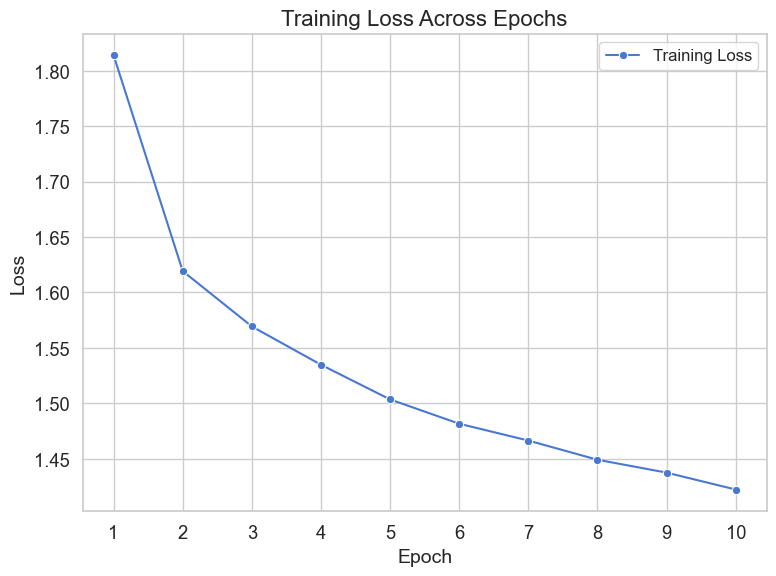

In [ ]:
#%%

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = {
    'epoch': list(range(1, 11)),  # 1 到 10 的 epoch
    'loss': lossdata
}
df = pd.DataFrame(df)
# 设置 Seaborn 样式
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)

# 绘制折线图
plt.figure(figsize=(8, 6))
sns.lineplot(data=df, x='epoch', y='loss', marker='o', label='Training Loss')

# 添加标题和标签
plt.title('Training Loss Across Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(df['epoch'])  # 设置 x 轴刻度
plt.legend(fontsize=12)
plt.tight_layout()

# 显示图表
plt.show()